In [1]:
import numpy as np
import copy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.distributions import Normal

import gym

from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear_layer = nn.Sequential(nn.Linear(in_features, out_features), nn.ReLU())
    def forward(self, x):
        x = self.linear_layer(x)
        return x

In [3]:
class ActorStochastic(nn.Module):
    def __init__(self, s_dim, a_dim, action_boundaries, hidden_dim=256, num_hidden_layers=2):
        super(ActorStochastic, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))

        self.f = nn.Sequential(*layers)
        self.mean = nn.Linear(hidden_dim, a_dim)
        self.log_std = nn.Linear(hidden_dim, a_dim)

        self.action_boundaries = action_boundaries

    def forward(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)

        out = self.f(state)
        mean = self.mean(out)
        log_std = self.log_std(out)
        
        log_std = torch.clamp(log_std, -20, 2)
        
        return mean, log_std

    def sampling(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mean, std)
        x_t = dist.rsample() #reparametrization trick implemented by pytorch
        action = torch.tanh(x_t) #Bounds the action
        log_prob = dist.log_prob(x_t) # Log probability(/ies if state in batch)
        log_Jacobian = torch.log(1-action**2+1e-10)#.sum(dim=1, keepdim=True)
        #print(log_Jacobian)
        log_prob = (log_prob-log_Jacobian).sum(dim=1, keepdim=True)
        return action, log_prob


In [4]:
class QDNN(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(QDNN, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim + a_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, 1))

        self.f = nn.Sequential(*layers)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        out = self.f(x)
        return out

In [5]:
class Critic(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(Critic, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        # Two DNNs to mitigate positive bias
        self.Q1 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)
        self.Q2 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)

    def forward(self, state, action):
        q1 = self.Q1(state, action)
        q2 = self.Q2(state, action)
        return q1, q2

In [2]:
class SAC():
    def __init__(self, s_dim, a_dim, hidden_dim_actor=256, hidden_dim_critic=256, 
                 num_layer_actor=2, num_layer_critic=2, lr_act=3e-4, lr_crit=3e-4, 
                 gamma=0.99, tau=0.005, alpha=0.2, lambd=0.005, target_upd_inter=1, 
                 buffer_capacity=int(1000), batch_size=32, grad_steps = 1, device="cpu"):
        
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.device = device
        self.batch_size = batch_size
        self.buffer = deque(maxlen=buffer_capacity)
        self.grad_steps = grad_steps

        self.alpha = alpha
        self.lambd = lambd
        self.gamma = gamma
        self.tau = tau
        self.target_upd_inter = target_upd_inter

        self.actor = ActorStochastic(s_dim, a_dim, hidden_dim_actor, num_hidden_layers=num_layer_actor).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_act)

        self.critic = Critic(s_dim, a_dim, hidden_dim_critic, num_hidden_layers=num_layer_critic).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr_crit)
        self.critic_target = copy.deepcopy(self.critic).to(device)

    def choose_action(self, state, evaluate=False):
        #print(state.shape)
        if evaluate:
            # Choosing action to give to the environnement and not train the model
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
                action, log_prob = self.actor.sampling(state)

            return action.cpu().detach().numpy()[0], log_prob
        
        state = torch.tensor(state, dtype=torch.float32, device=self.device)
        # To train actor model and critic
        action, log_prob = self.actor.sampling(state)
        
        return action, log_prob
    
    def critic_train(self, states, actions, rewards, next_states, dones):
        
        with torch.no_grad():
            next_actions, next_log_probs = self.choose_action(next_states, evaluate=False)
            q1_next, q2_next = self.critic_target(next_states, next_actions)
            min_q_next = torch.min(q1_next, q2_next)
            target_q_value = rewards + self.gamma *(torch.ones_like(dones)-dones).unsqueeze(1)*(min_q_next - self.alpha * next_log_probs)
            
        
        #print(target_q_value.shape)
        q1, q2 = self.critic(states, actions)
        #print(q1.shape, q2.shape)    
        critic_loss = F.mse_loss(q1, target_q_value) + F.mse_loss(q2, target_q_value)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        return critic_loss

    
    def actor_train(self, states):
        actions, log_probs = self.choose_action(states, evaluate=False)
        q1_actor, q2_actor = self.critic(states, actions)
        min_q_actor = torch.min(q1_actor, q2_actor)
            
        actor_loss = (self.alpha * log_probs - min_q_actor).mean(dim=0)

        #print(actor_loss)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        return actor_loss

    def train(self, update_interval):
        if len(self.buffer) < self.batch_size:
            return None, None

        for i in range(self.grad_steps):
            
            states, actions, rewards, next_states, dones = self.sample_batch()
            
            # Critic train
            self.critic.train()
            critic_loss= self.critic_train(states, actions, rewards, next_states, dones)

            # Actor train
            self.actor.train()
            actor_loss = self.actor_train(states)

            # Soft update of target networks
            if update_interval % self.target_upd_inter == 0:
                for target_parameters, parameters in zip(self.critic_target.parameters(), self.critic.parameters()):
                    target_parameters.data.copy_(self.tau * parameters.data + (1.0 - self.tau) * target_parameters.data)

        return critic_loss.item(), actor_loss.item()

    def add_elements_to_buffer(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample_batch(self):
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.float32).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        return states, actions, rewards, next_states, dones

## Mountain car continuous

In [113]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Independent
import random
import copy
import matplotlib.pyplot as plt

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv2d):
        nn.init.orthogonal_(m.weight.data, np.sqrt(float(2)))
        if m.bias is not None:
            m.bias.data.fill_(0)

# Define Linear Layer
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearLayer, self).__init__()
        self.linear_layer = nn.Sequential(nn.Linear(in_features, out_features), nn.ReLU())
    
    def forward(self, x):
        return self.linear_layer(x)

# Define Actor
class ActorStochastic(nn.Module):
    def __init__(self, s_dim, a_dim, action_space, hidden_dim=256, num_hidden_layers=2, device="cpu"):
        super(ActorStochastic, self).__init__()
        layers = [LinearLayer(s_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        
        self.f = nn.Sequential(*layers)
        
        self.mean = nn.Linear(hidden_dim, a_dim)
        self.log_std = nn.Linear(hidden_dim, a_dim)

        self.action_scale = torch.FloatTensor((action_space.high - action_space.low) / 2.0).to(device)
        self.action_bias = torch.FloatTensor((action_space.high + action_space.low) / 2.0).to(device)
        print(self.action_scale, self.action_bias)

    def forward(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)
        out = self.f(state)
        mean = self.mean(out)
        log_std = self.log_std(out)
        log_std = torch.clamp(log_std, -20, 2)
        return mean, log_std

    def sampling(self, state, repara=False):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        dist = Independent(Normal(loc=mean, scale=std), reinterpreted_batch_ndims=1)
        x_t = dist.rsample() if repara else dist.sample()  # Reparameterization trick
        squashed = torch.tanh(x_t)
        # log_prob = dist.log_prob(x_t)
        # log_prob -= torch.log(self.action_scale*(1 - squashed.pow(2) + 1e-6))
        # log_prob = log_prob.sum(1, keepdim=True)
        #print(dist.log_prob(x_t).shape, x_t.shape, F.softplus(-2*x_t).shape, (2*(np.log(2)-x_t-F.softplus(-2*x_t))).sum(dim=1, keepdim=True).shape)
        #print(squashed.shape, dist.log_prob(x_t).shape, (2*(np.log(2)-x_t-F.softplus(-2*x_t))).sum(dim=1).shape)
        log_prob = dist.log_prob(x_t)-(2*(np.log(2)-x_t-F.softplus(-2*x_t))).sum(dim=1)
        action = self.action_scale*squashed+ self.action_bias
        return action, log_prob.unsqueeze(1)

# Define Q Network
class QDNN(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(QDNN, self).__init__()
        layers = [LinearLayer(s_dim + a_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, 1))
        self.f = nn.Sequential(*layers)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.f(x)


# Define Critic
class Critic(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(Critic, self).__init__()
        self.Q1 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)
        self.Q2 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)


    def forward(self, state, action):
        q1 = self.Q1(state, action)
        q2 = self.Q2(state, action)
        return q1, q2

# Define Custom Replay Buffer
class ReplayBuffer:
    def __init__(self, s_dim, a_dim, buffer_capacity=1000000):
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.buffer_capacity = buffer_capacity
        self.size = 0
        self.ptr = 0

        self.states = np.zeros((buffer_capacity, s_dim), dtype=np.float32)
        self.actions = np.zeros((buffer_capacity, a_dim), dtype=np.float32)
        self.rewards = np.zeros((buffer_capacity, 1), dtype=np.float32)
        self.next_states = np.zeros((buffer_capacity, s_dim), dtype=np.float32)
        self.dones = np.zeros((buffer_capacity, 1), dtype=np.float32)

    def add(self, state, action, reward, next_state, done):
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_states[self.ptr] = next_state.squeeze()
        self.dones[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.buffer_capacity
        if self.size < self.buffer_capacity:
            self.size += 1

    def sample(self, batch_size):
        idxs = np.random.randint(0, self.size, size=batch_size)
        states = torch.FloatTensor(self.states[idxs])
        actions = torch.FloatTensor(self.actions[idxs])
        rewards = torch.FloatTensor(self.rewards[idxs])
        next_states = torch.FloatTensor(self.next_states[idxs])
        dones = torch.FloatTensor(self.dones[idxs])
        return states, actions, rewards, next_states, dones

# Define SAC
class SAC:
    def __init__(self, s_dim, a_dim, action_space, hidden_dim_actor=256, hidden_dim_critic=256, 
                 num_layer_actor=2, num_layer_critic=2, lr_act=3e-4, lr_crit=3e-4, 
                 gamma=0.99, tau=0.005, alpha=0.2, target_upd_inter=1, 
                 buffer_capacity=1000, batch_size=32, grad_steps = 1, device="cpu"):
        
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.device = device
        self.batch_size = batch_size
        self.target_upd_inter = target_upd_inter
        self.grad_steps = grad_steps

        self.alpha = alpha
        self.gamma = gamma
        self.tau = tau

        self.actor = ActorStochastic(s_dim, a_dim, action_space, hidden_dim_actor, num_hidden_layers=num_layer_actor, device=device).apply(init_weights).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_act)

        self.critic = Critic(s_dim, a_dim, hidden_dim_critic, num_hidden_layers=num_layer_critic).apply(init_weights).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr_crit)

        self.critic_target = Critic(s_dim, a_dim, hidden_dim_critic, num_hidden_layers=num_layer_critic).to(device)
        #self.critic_target = copy.deepcopy(self.critic).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        for p in self.critic_target.parameters():
            p.requires_grad = False

        self.replay_buffer = ReplayBuffer(s_dim, a_dim, buffer_capacity)

    def choose_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        if evaluate:
            with torch.no_grad():
                action, _ = self.actor.sampling(state, repara=False)
        else:
            action, _ = self.actor.sampling(state, repara=False)

        #print(action.shape, mean.shape)
            
        return action.cpu().detach().numpy()[0]
    
    def gradient_clipping(self, model) -> None:
        for param in model.parameters():
            param.grad.data.clamp_(-1, 1)

    def add_to_buffer(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)

    def train(self, update_interval):
        if self.replay_buffer.size < self.batch_size:
            return None, None

        actor_l = 0
        critic_l =0
        for _ in range(self.grad_steps):
            states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)
            #print(states.shape, actions.shape, rewards.shape, next_states.shape, dones.shape)
            with torch.no_grad():
                next_actions, next_log_probs = self.actor.sampling(next_states)
                q1_next, q2_next = self.critic_target(next_states, next_actions)
                min_q_next = torch.min(q1_next, q2_next) - self.alpha * next_log_probs
                #print(min_q_next.shape, next_log_probs.shape)
                q_target = rewards + (1 - dones) * self.gamma * min_q_next#.detach()
                #print(q_target.shape)
                

            q1, q2 = self.critic(states, actions)
            critic_loss = F.mse_loss(q1, q_target) + F.mse_loss(q2, q_target)

            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.gradient_clipping(self.critic)
            self.critic_optimizer.step()
            critic_l+=critic_loss.item()

            for param in self.critic.Q1.parameters():
                param.requires_grad = False
            for param in self.critic.Q2.parameters():
                param.requires_grad = False

            actions_sample, log_probs = self.actor.sampling(states, repara=True)
            q1_actor, q2_actor = self.critic(states, actions_sample)
            min_q_actor = torch.min(q1_actor, q2_actor)
            actor_loss = (self.alpha * log_probs - min_q_actor.detach()).mean()
            
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.gradient_clipping(self.actor)
            self.actor_optimizer.step()
            actor_l += actor_loss.item()

            for param in self.critic.Q1.parameters():
                param.requires_grad = True
            for param in self.critic.Q2.parameters():
                param.requires_grad = True

            if update_interval% self.target_upd_inter==0:
                for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

        return critic_loss.item(), actor_loss.item()


In [114]:
env = gym.make('Pendulum-v1')
reward_scale = 1  # Example scaling factor
env = scale_reward(env, reward_scale)

s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
agent = SAC(s_dim, a_dim, env.action_space,  buffer_capacity=int(1e6), hidden_dim_actor = 64, hidden_dim_critic=64, 
            num_layer_actor=3, num_layer_critic=3, lr_act=1e-3, lr_crit=1e-3, alpha=0.1, tau=0.99, grad_steps=1, batch_size=64, device="cuda")

score_history = train_SAC(agent, env, 200, training_interval=1, update_interval=1, print_num_episodes=1)
plot_scores(score_history)

c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym

tensor([2.], device='cuda:0') tensor([0.], device='cuda:0')
episode 0 score -877.1 avg score -877.1
22992.19140625 763.8148193359375
episode 1 score -1528.8 avg score -1202.9
1865307.0 8844.4765625
episode 2 score -894.9 avg score -1100.3
2055099.0 12674.720703125
episode 3 score -1189.8 avg score -1122.7
143900.796875 9020.27734375
episode 4 score -1297.9 avg score -1157.7
522851.875 3771.3359375
episode 5 score -1608.8 avg score -1232.9
211653.0625 4084.4130859375
episode 6 score -1466.4 avg score -1266.2
60197.7734375 5700.3623046875
episode 7 score -1418.9 avg score -1285.3
98714.2890625 3898.946044921875
episode 8 score -1547.7 avg score -1314.5
1704714.75 6098.8583984375
episode 9 score -761.2 avg score -1259.1
58355.5859375 5605.70068359375
episode 10 score -884.4 avg score -1259.9
45487.0703125 4045.0869140625
episode 11 score -1793.9 avg score -1286.4
140707.53125 8390.138671875
episode 12 score -1067.0 avg score -1303.6
11461.296875 4001.720703125


In [51]:
# # Create the environment
# env = gym.make('MountainCarContinuous-v0')

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Hyperparameters
# s_dim = env.observation_space.shape[0]
# a_dim = env.action_space.shape[0]
# action_space = env.action_space
# print(action_space)
# hidden_dim_actor = 64
# hidden_dim_critic = 64
# num_layer_actor = 1
# num_layer_critic = 1
# lr_act = 1e-4
# lr_crit = 1e-4
# gamma = 0.99
# tau = 0.05
# alpha = 0.2
# batch_size = 64
# num_episodes = 100
# update_interval = 1
# target_upd_inter = 1
# buffer_capacity = 10000
# num_warmup = 1000

# # Initialize SAC agent
# agent = SAC(s_dim, a_dim, action_space, hidden_dim_actor, hidden_dim_critic, 
#             num_layer_actor, num_layer_critic, lr_act, lr_crit, gamma, tau, 
#             alpha, buffer_capacity, batch_size, device)


# # Training loop
# episode_rewards = []
# step_warmup = 0
# for episode in range(num_episodes):
#     state, _ = env.reset()
#     episode_reward = 0
#     for t in range(999):
#         action = agent.choose_action(state, evaluate=True)
#         next_state, reward, done, _, _ = env.step([action])
#         agent.add_to_buffer(state, action, reward, next_state, done)
#         state = next_state
#         episode_reward += reward
        
#         if step_warmup>num_warmup:
#             if t % update_interval == 0:
#                 agent.update_parameters(update_interval)
#         else:
#             step_warmup+=1

#         if done:
#             break

#     episode_rewards.append(episode_reward)
#     if (episode + 1) % 5 == 0:
#         print(f"Episode {episode + 1}, Reward: {episode_reward}")

# # Plotting
# plt.plot(episode_rewards)
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.title('SAC on MountainCarContinuous-v0')
# plt.show()

In [52]:
### Plot the learning progress
def plot_scores(score_history):
    # Create the plot
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    # Plot the scores with specified colors and labels
    ax.plot(np.arange(1, len(score_history) + 1), score_history, color='green', label='SAC')

    # Set the labels with a larger font size
    ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
    ax.set_xlabel('Episode #', fontsize=20)

    # Set the tick labels to a larger font size
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Add a legend with a specified font size
    ax.legend(fontsize=20)

    # Show the plot
    plt.show()

In [60]:
def train_SAC(agent, env, n_games, training_interval=1, update_interval=1, print_num_episodes=10):
    
    n_games = n_games

    best_score = env.reward_range[0]
    score_history = []

    avg_score = 0
    n_steps = 0
    training_interval=training_interval
    update_interval = update_interval
    warmup = 100

    for i in range(n_games):
        state = env.reset()
        done = False
        score = 0
        for _ in range(200):
            if warmup<n_steps:
                action = agent.choose_action(state, evaluate=True)
            else :
                action = env.action_space.sample()

            next_state, reward, done, _ = env.step([action])
            score += reward
            agent.add_to_buffer(state, action, reward, next_state, done)
            state = next_state.squeeze()
            update_interval += 1
            n_steps += 1
            if n_steps % training_interval == 0:
                critic_loss, actor_loss = agent.train(update_interval)
            if done:
                break

        score_history.append(score)
        avg_score = np.mean(score_history[-10:])
        if i%print_num_episodes == 0:
            print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score)
            print(critic_loss, actor_loss)
    
    env.close()

    return score_history

## Mountain car continuous

In [45]:
env = gym.make('MountainCarContinuous-v0')

s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
agent = SAC(s_dim, a_dim, env.action_space, buffer_capacity=int(5e5), hidden_dim_actor = 64, hidden_dim_critic=64, 
            num_layer_actor=1, num_layer_critic=1, lr_act=3e-5, lr_crit=3e-5, alpha=0.1,gamma=1,tau=0.01, batch_size=512, grad_steps=1, device="cuda")

score_history = train_SAC(agent, env, 200, training_interval=64, update_interval=128, print_num_episodes=1)
plot_scores(score_history)

c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym

tensor([1.], device='cuda:0') tensor([0.], device='cuda:0')
episode 0 score -40.3 avg score -40.3
0.006383098661899567 -0.07244058698415756
episode 1 score -40.2 avg score -40.3
0.004982287529855967 -0.08368213474750519
episode 2 score -41.3 avg score -40.6
0.004791480954736471 -0.08633096516132355
episode 3 score -42.3 avg score -41.1
0.004109279252588749 -0.09202234447002411
episode 4 score -38.6 avg score -40.6
0.004047255031764507 -0.09919430315494537
episode 5 score -40.6 avg score -40.6
0.0036762775853276253 -0.10208681970834732
episode 6 score -39.4 avg score -40.4
0.003534425050020218 -0.10729130357503891
episode 7 score -38.7 avg score -40.2
0.0030260044150054455 -0.11255401372909546
episode 8 score -38.7 avg score -40.0
0.002824080642312765 -0.11815676093101501
episode 9 score -39.8 avg score -40.0
0.0026043406687676907 -0.1175815612077713
episode 10 score -40.2 avg score -40.0
0.0026553261559456587 -0.12480642646551132
episode 11 score -39.8 avg score -40.0
0.002316181547939

KeyboardInterrupt: 

In [38]:
agent.actor_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

## Pendulum-v1

In [61]:
def scale_reward(env, reward_scale):
    """
    Scales the rewards of an environment.

    Parameters:
    - env (gym.Env): OpenAI Gym environment.
    - reward_scale (float): Scaling factor for rewards.

    Returns:
    - env_scaled (gym.Env): Scaled OpenAI Gym environment.
    """
    class ScaledRewardEnv(gym.Env):
        def __init__(self, env, reward_scale):
            super(ScaledRewardEnv, self).__init__()
            self.env = env
            self.reward_scale = reward_scale

            self.action_space = env.action_space
            self.observation_space = env.observation_space

        def step(self, action):
            obs, reward, done, info = self.env.step(action)
            return obs, reward * self.reward_scale, done, info

        def reset(self):
            return self.env.reset()

        def render(self, mode='human'):
            return self.env.render(mode)

        def close(self):
            return self.env.close()

        def seed(self, seed=None):
            return self.env.seed(seed)

    env_scaled = ScaledRewardEnv(env, reward_scale)
    return env_scaled

c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym

tensor([2.], device='cuda:0') tensor([0.], device='cuda:0')
episode 0 score -1515.3 avg score -1515.3
3.035292148590088 10.344452857971191
episode 1 score -1174.1 avg score -1344.7
14.64004135131836 27.327022552490234
episode 2 score -983.5 avg score -1224.3
2.326014995574951 42.191871643066406
episode 3 score -1235.0 avg score -1227.0
5.7039794921875 56.92253875732422
episode 4 score -868.0 avg score -1155.2
37.61578369140625 64.48893737792969
episode 5 score -1187.9 avg score -1160.6
8.698343276977539 84.44570922851562
episode 6 score -1723.9 avg score -1241.1
149.32479858398438 97.94355010986328
episode 7 score -1266.0 avg score -1244.2
18.23525047302246 118.06604766845703
episode 8 score -1511.8 avg score -1274.0
24.711105346679688 131.60247802734375
episode 9 score -896.5 avg score -1236.2
330.45391845703125 145.87295532226562
episode 10 score -1461.5 avg score -1230.8
213.0397491455078 160.45245361328125
episode 11 score -1137.5 avg score -1227.2
47.75262451171875 169.22700500488

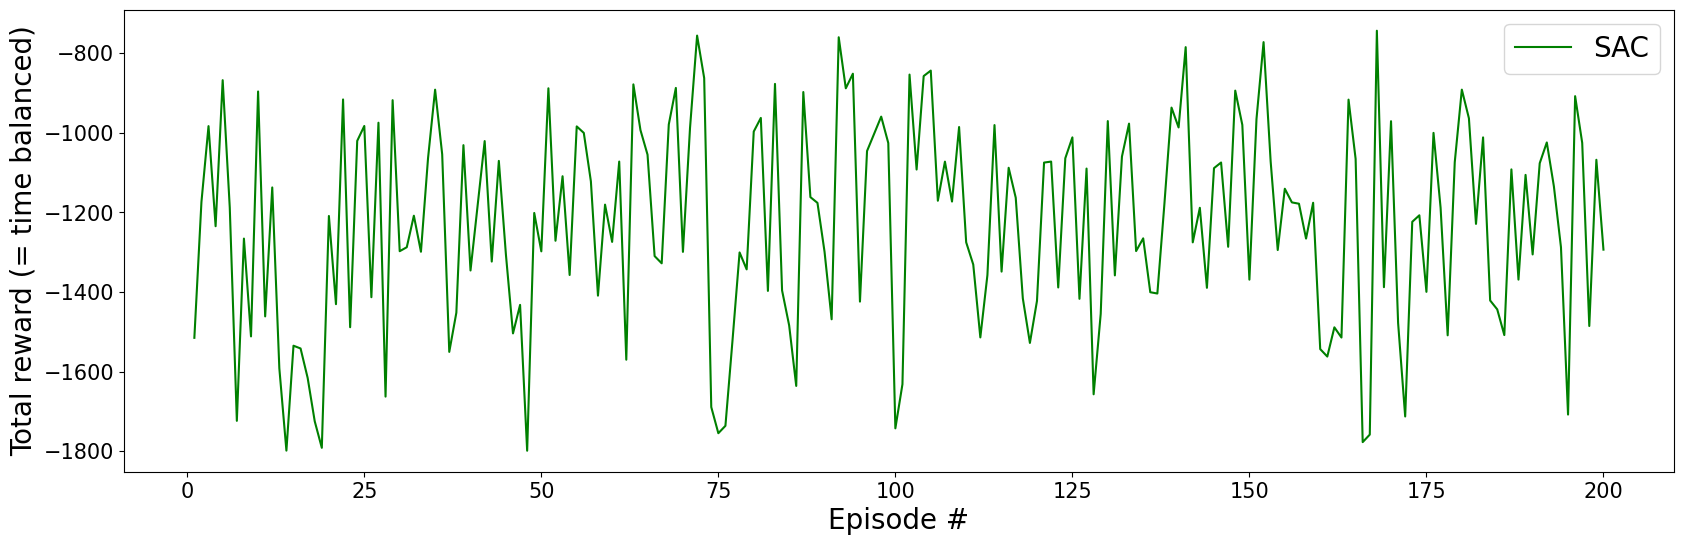

In [67]:
env = gym.make('Pendulum-v1')
reward_scale = 1  # Example scaling factor
env = scale_reward(env, reward_scale)

s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
agent = SAC(s_dim, a_dim, env.action_space,  buffer_capacity=int(1e5), hidden_dim_actor = 64, hidden_dim_critic=64, 
            num_layer_actor=1, num_layer_critic=1, lr_act=3e-4, lr_crit=3e-4, alpha=0.2, tau=0.005, grad_steps=3, batch_size=126, device="cuda")

score_history = train_SAC(agent, env, 200, training_interval=1, update_interval=1, print_num_episodes=1)
plot_scores(score_history)